# Gradient descent and functional derivatives
Consider the function $f(x)$ for $x \in \mathbb{R}^n$. Stationary points of $f$ are found at points where $\nabla f(x) = 0$. The **method of gradient descent** can be used to find (approximations to) minima of $f$.

The Taylor expansion says that when the argument to $f$ is perturbed by a small amount, then the response of $f$ is linearly proportional to the perturbation, plus higher-order effects:
$$ f(x + \delta x) = f(x) + \delta x \cdot \nabla f(x) + o(|\delta x|). $$
Given an initial guess $x_0$, we construct a sequence of approximations $x_n$ by taking
$$
x_{n+1} = x_n - \gamma \nabla f(x_n),
$$
where $\gamma > 0$ is a rate of descent, typically small. Each approximation reduces $f$, because
\begin{align}
f(x_{n+1}) &= f(x_n - \gamma \nabla f(x_n)) \\
           &\sim f(x_n) - \gamma \nabla f(x_n) \cdot \nabla f(x_n) \\
           &\leq f(x_n).
\end{align}
The rate of convergence and the stability of this method depend on both the rate of descent, and on the magnitude of the higher-order terms (usually second-order). Note that convergence towards the _global_ minimum (or indeed any particular minimum) is not guaranteed, and more sophisticated methods such as the [method of _stochastic_ gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) are needed to treat such functions.

In [611]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    return (x[0] - x[1])**2 + np.cos(x[1])

def gradf(x):
#     print(x)
    grad = np.array([2*(x[0] - x[1]), 2*(x[1] - x[0]) - np.sin(x[1])])
#     print(grad)
    return grad

def gradient_descent(f, gradf, x0, rate=0.01, abstol=1e-5, min_steps=10, max_steps=2000):
    guesses = np.array([x0])
    fs = np.array([f(x0)])
    while (min_steps > len(guesses)
          or abs(fs[-1] - fs[-2]) > abstol) \
          and len(guesses) < max_steps:
        x_prev = guesses[-1]
        x_new = x_prev - rate * gradf(x_prev)
        guesses = np.append(guesses, [x_new], axis=0)
        fs = np.append(fs, f(x_new))
#         print(len(guesses))
    return guesses, fs
    

In [477]:
min_steps = 10
max_steps = 500
rate = 0.03
abstol = 1e-5
x0 = [2.4, -1.3]
guesses, fs = gradient_descent(f, gradf, x0, rate, abstol, min_steps, max_steps)

The following example demonstrates gradient descent in a 2D problem.

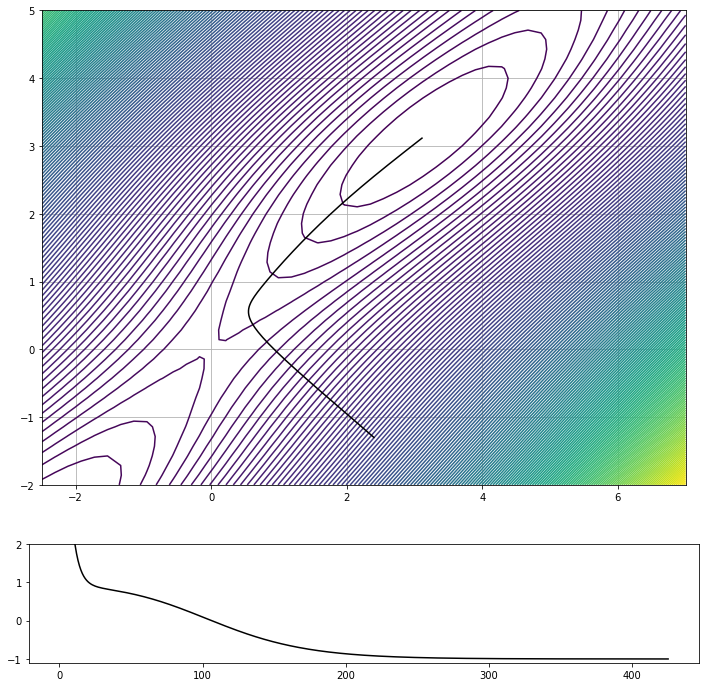

In [478]:
xpg, ypg = np.meshgrid(np.linspace(-2.5, 7), np.linspace(-2, 5))
fig, axs = plt.subplots(2, 1, figsize=[12, 12], gridspec_kw={'height_ratios': [4, 1]})
axs[0].plot(guesses[:,0], guesses[:,1], 'k-')
axs[0].contour(xpg, ypg, f([xpg, ypg]), 200)
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid()

axs[1].plot(fs, 'k-')
axs[1].set_ylim([-1.1, 2])

plt.show()

We can do something similar when trying to minimise a _functional_. The idea here is that the first variation of a functional is like the gradient operation, and the key is to make perturbations in the opposite direction of the gradient.

Consider
$$ F[y] = \int_a^b f(x, y, y') \mathrm{d}x. $$
The first variation is
\begin{align}
\delta F &= F[y + \delta y] - F[y] \\
         &= \int_a^b \left( f_y - (f_{y'})' \right) \delta y \mathrm{d} x + o(|\delta y|).
\end{align}
(The higher-order terms are bounded by the magnitude of the perturbation $\delta y$ in some functional norm.)

You will recognise the quantity inside the brackets as the terms in the Euler-Lagrange equation: $\delta F = 0$ for all $\delta y$ means that the brackets must be zero. Let us call this $\delta F /\delta y = f_y - (f_{y'})'$. Recognise also that the integral can be thought of as the inner product of the two functions in the integrand, so 
$$
\delta F = \left\langle \frac{\delta F}{\delta y}, \delta y \right\rangle.
$$
Armed with this idea, we can now use the method of gradient descent to find successive approximations to the minimising function. Again given an initial guess $y_0(x)$, we construct
\begin{align}
y_{n+1}(x) &= y_n(x) - \frac{\delta F}{\delta y} \\
           &= y_n(x) - \gamma \left( f_y(x, y_n, y'_n) - (f_{y'}(x, y_n, y'_n)' \right).
\end{align}
Each of these approximations will reduce $F[y]$. 

This time, we need to discretise our interval into $n$ points and then approximate $y(x)$ as an $n$-dimensional vector. However, the concept is otherwise the same. While it may be tempting to take very large $n$, the discretisation is unstable if the rate of descent is too large compared to the spatial step size.

Instead of our own implementation of gradient descent, we'll use the `scipy.optimize.minimize` function, which uses more sophisticated algorithms. See [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) for more information. But the idea is the same.

In [686]:
from scipy.optimize import minimize

def ddx(ys, dx=1):
    """Return the derivative of an array, calculated using a
    second-order finite difference scheme. Central differences
    are used except at the boundaries, where forward and
    backward differences are used.
    """
    return np.array([-0.5*ys[2] + 2*ys[1] - 1.5*ys[0],  
                     *(ys[2:] - ys[:-2])/2, 
                     0.5*ys[-3] - 2*ys[-2] + 1.5*ys[-1]]) / dx

## Variational Principles, Sheet 1, question 5: The soap film

With a little dimensional analysis, it can be seen that the solution depends on the dimensionless ratio $a/b$. In this demo, we keep $b=1$ fixed and vary $a$. What happens if $a$ is reduced below 1.6?

In [692]:
@interact(width=widgets.FloatSlider(min=1.4, max=4, value=1.7, 
                                      continuous_update=False))
def soap_film(width):
    xs = np.linspace(-1, 1, 201)
    dx = xs[1] - xs[0]
    ys0 = width * np.ones(xs.shape) # - 0.1*np.sin(np.pi * xs) # + xs * (1-xs) 

    cons = ({'type': 'eq', 'fun': lambda x:  x[0] - width},
            {'type': 'eq', 'fun': lambda x: x[-1] - width})

    def functional(ys):
        return np.trapz(ys * np.sqrt(1 + ddx(ys, dx) ** 2), dx=dx)

    # def variation(ys):
    #     funcderiv = np.sqrt(1 + deriv(ys, dx) ** 2) - deriv(ys * deriv(ys, dx) / np.sqrt(1 + deriv(ys, dx) ** 2), dx)

    res = minimize(functional, ys0, constraints=cons)    
    
    fig, axs = plt.subplots(1, 1, figsize=[6, 8])
    axs.plot(res.x, xs, 'k-')
    axs.set_aspect('equal', adjustable='box')
    axs.set_xlim([-0.1, 4.1])
    axs.grid()

interactive(children=(FloatSlider(value=1.7, continuous_update=False, description='width', max=4.0, min=1.4), …